In [1]:
import sys
import numpy as np
import math
import pandas as pd
import random

from scipy import stats

%matplotlib inline

import matplotlib.pyplot as plt 
import matplotlib
matplotlib.rc('font',family='serif')
matplotlib.rc('font',weight='bold')
matplotlib.rc('font',size=16)
matplotlib.rcParams['axes.labelweight'] = 'bold'

In [2]:
week = 'Week2'
day  = 'Tues'

In [137]:
# Get the ratings by user ID: starts at user index 1 
r = pd.read_csv('goodbooks-10k/ratings.csv')
df_ratings = pd.DataFrame(r)

# Add counts to the df
cut = 175
df_ratings['user_counts'] = df_ratings.groupby(['user_id'])['book_id'].transform('count')
df_ratings['book_counts'] = df_ratings.groupby(['book_id'])['user_id'].transform('count')
df_ratings_cut = df_ratings.query('user_counts > %d'%cut)
# Add an index for the user for matrix making later
df_ratings_cut['user_idx'] = pd.Categorical(df_ratings_cut['user_id']).codes - 1
df_ratings_cut['book_idx'] = pd.Categorical(df_ratings_cut['book_id']).codes - 1

# ...but also do a groupby, so can plot easily
df_ratings_count_u = df_ratings.groupby(['user_id']).size().reset_index(name='Counts')
df_ratings_count_u_cut = df_ratings_count_u.query('Counts > %d'%cut)

df_ratings_book_count_u = df_ratings.groupby(['book_id']).size().reset_index(name='Counts')
#df_ratings_book_count_u_cut = df_ratings_book_count_u.query('Counts > %d'%cut)



# Get the ratings by book 
r = pd.read_csv('goodbooks-10k/books.csv')
df_books = pd.DataFrame(r)
df_books.head()
df_books_cut = df_books.query('ratings_count < 30000')

# Set number of books and users variables for later use
N_BOOKS = df_books.shape[0]
#N_USERS = len(df_ratings.user_id.unique())
N_USERS = len(df_ratings_count_u_cut.user_id.unique())
N_USERS_TEST = 1000
N_FEATURES = 40
LEAVE_OUT_PERC = 0.2

print(N_BOOKS,N_USERS)# ,df_ratings_count_u_cut.shape[0])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


10000 537


In [142]:
df_ratings_book_count_u.head()

,book_id,Counts
0,1,22806
1,2,21850
2,3,16931
3,4,19088
4,5,16604


In [135]:
#df_ratings.head()
df_ratings_cut.head()
#df_books.head()
#plt.hist(df_ratings_cut.book_idx.values)

,user_id,book_id,rating,user_counts,book_counts,user_idx,book_idx
2921,173,14,4,176,14328,0,12
2922,173,782,4,176,1886,0,780
2923,173,531,3,176,2643,0,529
2924,173,763,4,176,1700,0,761
2925,173,646,3,176,2723,0,644


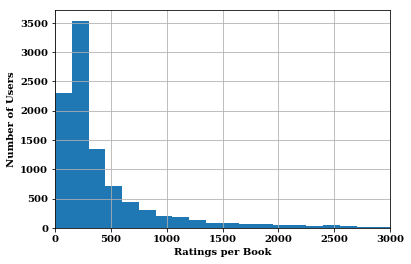

In [158]:
plt.figure(figsize=(6,4))
plt.hist(df_ratings_book_count_u['Counts'].values,bins=20,range=(0,3000))
plt.xlim(0,3000)
#plt.ylim(0,12500)
plt.grid(True)
#plt.axvline(cut,label='Cut = %d'%cut,color='r',lw=3,ls='--')
plt.xlabel('Ratings per Book')
plt.ylabel('Number of Users')
#plt.legend()
plt.savefig('Plots/%s_%s_ratings_per_book_w_cut.png'%(week,day))



## Get Ratings/User and Ratings/Book

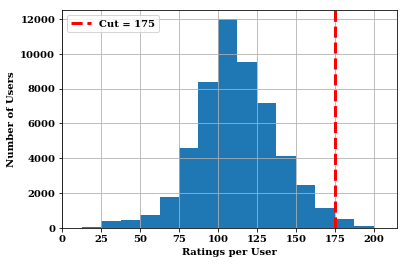

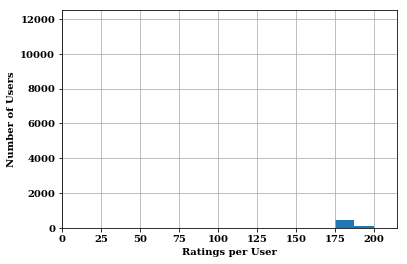

In [146]:
# Ratings
plt.figure(figsize=(6,4))
plt.hist(df_ratings_count_u['Counts'].values,bins=20,range=(0,250))
plt.xlim(0,215)
plt.ylim(0,12500)
plt.grid(True)
plt.axvline(cut,label='Cut = %d'%cut,color='r',lw=3,ls='--')
plt.xlabel('Ratings per User')
plt.ylabel('Number of Users')
plt.legend()
plt.savefig('Plots/%s_%s_ratings_per_user.png'%(week,day))

# Ratings with cut on number of user responses
plt.figure(figsize=(6,4))
plt.hist(df_ratings_count_u_cut['Counts'].values,bins=20,range=(0,250))
plt.xlim(0,215)
plt.ylim(0,12500)
plt.grid(True)
plt.xlabel('Ratings per User')
plt.ylabel('Number of Users')
plt.savefig('Plots/%s_%s_ratings_per_user_cut.png'%(week,day))

# Ratings with cut on number of user responses
# plt.figure(figsize=(6,4))
# _,_,_ = plt.hist(df_books.ratings_count.values,range=(0,300000),bins=20)
# plt.grid(True)
# plt.xlabel('Ratings per Book')
# plt.ylabel('Number of Book')
# plt.xlim(0,300000)
# plt.savefig('Plots/%s_%s_ratings_per_book.png'%(week,day))

## Build a Rant Matrix

In [147]:
from validation_figs import *

In [148]:
# First, define a matrix size num_books x num_users
ratings_mat = np.zeros((N_BOOKS,N_USERS))
binary_mat = np.zeros((N_BOOKS,N_USERS))
Y, R = ratings_mat, binary_mat

# Now fill the rank matrix and validation matrix
for i in range(df_ratings_cut.shape[0]):
    user_i = df_ratings_cut.user_idx.values[i]
    book_i = df_ratings_cut.book_id.values[i]
    rating_i = df_ratings_cut.rating.values[i]
    
    ratings_mat[book_i - 1][user_i] = rating_i
    binary_mat[book_i - 1][user_i] = 1


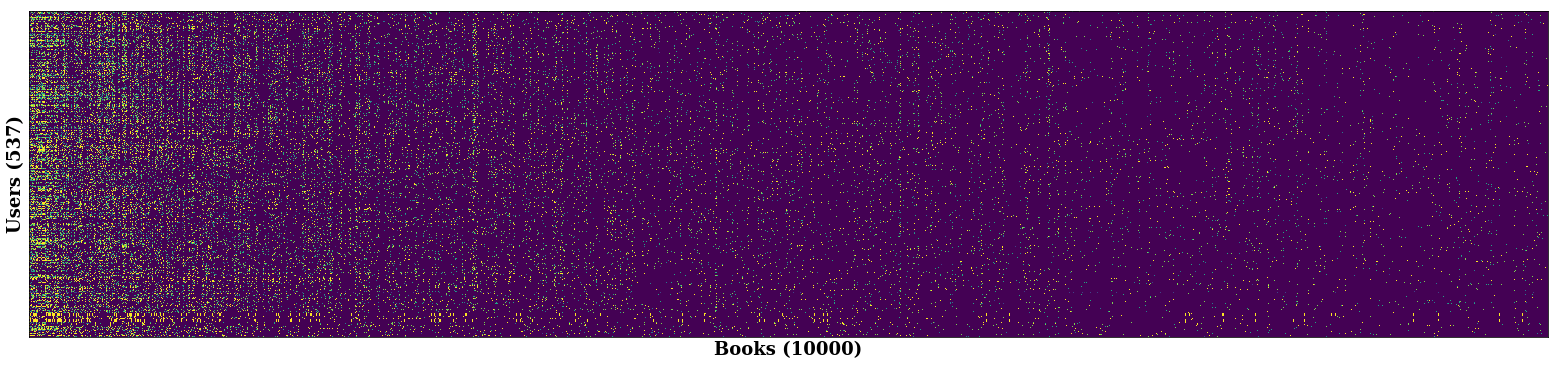

In [174]:
# "Visualize the ratings matrix"
fig = plt.figure(figsize=(40,6)) # 10*(10000./537)))
plt.imshow(ratings_mat.T)
#plt.colorbar()
plt.xlabel('Books (%d)'%N_BOOKS,fontsize=18)
plt.ylabel('Users (%d)'%N_USERS,fontsize=18)
plt.xlim(0,2500)
plt.xticks([])
plt.yticks([])
plt.savefig('Plots/%s_%s_matrix_size.png')

In [179]:
# Find similarity between users
similarity = np.zeros((N_USERS,N_USERS))

for i in range(N_USERS): #len(a.shape[0])):
    r1 = ratings_mat.T[i]
    for j in range(i,N_USERS): #len(a.shape[0])):
        r2 = ratings_mat.T[j]
        
        a_mag = np.linalg.norm(r1)
        b_mag = np.linalg.norm(r2)

        c = r1.dot(r2) / a_mag / b_mag

        if c < 0.9999:
            similarity[i][j] = c
        if c > 0.7 and c < 0.99999999:
            print("Similar!",i,j,c)

Similar! 75 130 0.5062868480310855
Similar! 175 185 0.5099423360800374
Similar! 286 432 0.5276169792713157
Similar! 439 534 0.5678051482714019
Similar! 474 490 0.5277492982577923
Similar! 498 499 0.9402629120070765
Similar! 498 500 0.9350680892888054
Similar! 498 501 0.9402629120070765
Similar! 498 507 0.6403550688482851
Similar! 498 508 0.6685043893981081
Similar! 498 509 0.6757709549343939
Similar! 498 510 0.5968913630506648
Similar! 498 511 0.6283066979480683
Similar! 499 500 0.9322916666666666
Similar! 499 501 0.9374999999999998
Similar! 499 507 0.6314085854672882
Similar! 499 508 0.6649655212001796
Similar! 499 509 0.6721936196477037
Similar! 499 510 0.5879447357921311
Similar! 499 511 0.629940788348712
Similar! 500 501 0.9687499999999999
Similar! 500 507 0.6367145399670133
Similar! 500 508 0.6649655212001796
Similar! 500 509 0.6721936196477037
Similar! 500 510 0.5984437489312764
Similar! 500 511 0.629940788348712
Similar! 501 507 0.6420204944667384
Similar! 501 508 0.670243025336

In [193]:
# Let's say we're interested in results for user i = 0
user_i = 0
most_similar_users = np.argsort(similarity[user_i])
most_similar_users = most_similar_users[::-1]
print(most_similar_users[:10])

# pred_idxs_sorted = pred_idxs_sorted[::-1]

# print(pred_idxs_sorted)

# print( "Top recommendations for you:")
# for i in range(6):
#     new_book = df_books.query('book_id == %d'%pred_idxs_sorted[i])
#     print('Predicting rating %0.1f for book "%s"' % \
#     (predictions[pred_idxs_sorted[i]],new_book['title'].values[0]))
    
# print ("\nOriginal ratings provided:")
# for i in range(len(orig_ratings)):
#     if orig_ratings[i] > 0:
#         #print ('here we are ', i)
#         new_book_2 = df_books.query('book_id == %d' % i)
#         print ('Rated %d for "%s"' % (orig_ratings[i],new_book_2['title'].values[0]))

[395 294 383 351  60 133 317 140 209 228]


Text(0,0.5,'Users')

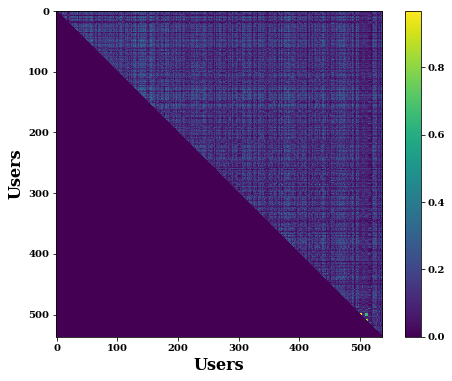

In [183]:
# Visualize the similarity
plt.figure(figsize=(8,6))
plt.imshow(similarity)
plt.colorbar()
plt.xlabel('Users',fontsize=16)
plt.ylabel('Users',fontsize=16)

In [219]:

#print(c)

(10000, 537)


In [242]:
mask = np.ones(ratings_mat.shape)

perc = 0.2 # 20 percent
max_e = int(0.2*N_USERS)
print("Masking %d values "%max_e)

for i in mask:
    i[:max_e] = 0
    np.random.shuffle(i)

reverse_mask = (mask - 1) *-1 + 0
#print(mask[0],reverse_mask[0])
#print(np.sum(mask[0]))

train_set = ratings_mat*mask
test_set = ratings_mat*reverse_mask
print( test_set)

Masking 107 values 
[[4. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 5. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [225]:
test_ind = np.random.permutation(12)[:4]
print(test_ind)

[3 6 0 2]


In [37]:
mask = np.random.randint(0,2,size=ratings_mat.shape).astype(np.bool)

# random matrix the same shape of your data
r = np.random.rand(*ratings_mat.shape)*np.max(ratings_mat)

# use your mask to replace values in your input array
#x[mask] = r[mask]
print(r)

[[3.49959177 0.11280502 4.67650874 ... 2.75247763 4.21709534 1.79383402]
 [3.28757292 2.47242129 0.73442205 ... 0.51811789 3.81571802 3.05863133]
 [1.88804117 3.5095965  4.08413917 ... 0.57301813 3.21089317 1.71492368]
 ...
 [3.62878567 3.43121803 0.15573951 ... 1.4396967  2.86773625 2.04234095]
 [3.1926569  3.19283734 4.03542469 ... 0.76812484 2.17471408 2.91402349]
 [4.73532976 3.74124458 1.58331391 ... 0.72623132 4.15883245 0.26713112]]


In [36]:
#print(np.round(Permission*100))
print (np.where(ratings_mat > 0)[0])

[   0    0    0 ... 9999 9999 9999]


In [16]:
a = ratings_mat.ravel()
leave_k_out(ratings_mat.copy(),_)
#print(a.shape)


N_user, M_item = uim.shape
uim = uim.ravel()
entries = np.where(uim > 0)[0] #== fill_num)[0]

N = entries.size
N_TEST = np.round(LEAVE_OUT_PERC * N_USERS)
test_ind = np.random.permutation(N)[:N_TEST]
uim[entries[test_ind]] = test_num



/Users/ah673/WorkArea/DataInsight/Books/validation_figs.py:38: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  entries = np.where(uim == fill_num)[0]


TypeError: slice indices must be integers or None or have an __index__ method

## Build Rank Matrix

In [6]:
# First, define a matrix size num_books x num_users
# Also, define a rank matrix of same shape with 0 or 1 if a user has ranked a movie
validate = 1000
test = 1000

print('check this', N_USERS,validate)

ratings_mat = np.zeros((N_BOOKS,N_USERS - validate)) # - test))
binary_mat = np.zeros((N_BOOKS,N_USERS - validate))  # - test))
Y, R = ratings_mat, binary_mat

val_ratings_mat = np.zeros((N_BOOKS,validate)) # - test))
val_binary_mat = np.zeros((N_BOOKS,validate))  # - test))
offset = ratings_mat.shape[1]
#print(ratings_mat.shape,N_USERS - validate) # - test,offset)

# Now fill the rank matrix and validation matrix
for i in range(df_ratings.shape[0]):
        
    user_i = df_ratings.user_id.values[i]
    book_i = df_ratings.book_id.values[i]
    rating_i = df_ratings.rating.values[i]
    
    if user_i <= N_USERS - validate: # - test:
        ratings_mat[book_i - 1][user_i - 1] = rating_i
        binary_mat[book_i - 1][user_i - 1] = 1
    else:
        #print(user_i,book_i,rating_i)
        val_ratings_mat[book_i - 1][user_i - 1 - offset] = rating_i
        val_binary_mat[book_i - 1][user_i - 1 - offset] = 1

check this 53424 1000


In [7]:
print("Ratings matrix training size :",ratings_mat.shape)
print("Ratings matrix validation size :", val_ratings_mat.shape)

Ratings matrix training size : (10000, 52424)
Ratings matrix validation size : (10000, 1000)


In [21]:
def cost(x_theta, y, R, u, lam = 0.):
    
    x = x_theta[:N_BOOKS*N_FEATURES].reshape((N_BOOKS,N_FEATURES))
    theta = x_theta[N_BOOKS*N_FEATURES:].reshape((N_USERS,N_FEATURES))
    
    h = np.dot(x,theta.T)
    # Only take into account rated movies (mult with R)
    h_R = np.multiply(h,R) - y

    # Include regularization
    cost = 0.5 * np.sum( pow(h_R,2) )\
        + (lam/2.) *( np.sum(np.square(theta)) + np.sum(np.square(x))) 
   
    print('Cost',cost)
    return float(cost) 

def grad(x_theta, y, R, u, lam=0.):
    
    x = x_theta[:N_BOOKS*N_FEATURES].reshape((N_BOOKS,N_FEATURES))
    theta = x_theta[N_BOOKS*N_FEATURES:].reshape((u,N_FEATURES))
      
    #print('and here are x and theta ', x.shape,theta.shape)
    h = np.dot(x,theta.T)    
    #print('and here are h and R and Y ', h.shape,R.shape,y.shape)
    h_R = np.multiply(h,R) - y
    
    x_grad = h_R.dot(theta) + lam * x
    theta_grad = h_R.T.dot(x) + lam * theta
    
    X_flat = x_grad.reshape([-1,1])
    Theta_flat = theta_grad.reshape([-1,1])
    X_Theta_flat = np.concatenate((X_flat,Theta_flat))
  
    return X_Theta_flat.reshape(len(X_Theta_flat),)
    
# Function that reshapes X and Theta
def reshape(flat, nbooks, nusers, nfeatures):
    assert flat.shape[0] == int(N_BOOKS*N_FEATURES + N_USERS*N_FEATURES)
    
    x = flat[:int(nbooks*nfeatures)].reshape((nbooks,nfeatures))
    theta = flat[int(nbooks*nfeatures):].reshape((nusers,nfeatures))
    
    return x, theta

In [22]:
#from ahack_functions import cost, grad, reshape

In [30]:
orig_ratings = np.zeros((N_BOOKS,1))
orig_ratings[473]  = 5
orig_ratings[1325] = 5
orig_ratings[1911] = 5
orig_ratings[2207] = 5
orig_ratings[2888]  = 5
orig_ratings[7240]  = 5
orig_ratings[551]  = 5
orig_ratings[61]  = 5
orig_ratings[1433] = 5
orig_ratings[1508] = 5
orig_ratings[200] = 5

Y, R = ratings_mat, binary_mat
Y_new = np.hstack((Y,orig_ratings))
R_new = np.hstack((R,orig_ratings > 0))
N_BOOKS, N_USERS = Y_new.shape

In [31]:
print(N_USERS,N_USERS,X_mat.shape,Theta_mat.shape,X_Theta_rand.shape)
# print(Theta_mat.shape)

52425 52425 (10000, 40) (52425, 40) (2497000, 1)


In [32]:
# X is N_BOOKS × N_FEATURES (40) matrix 
# Theta is N_USERS × N_FEATURES (40) matrix
X_mat = np.random.rand(N_BOOKS,N_FEATURES)
Theta_mat = np.random.rand(N_USERS,N_FEATURES)

X_Theta_rand = np.concatenate((X_mat.reshape([-1,1]),Theta_mat.reshape([-1,1])))

In [33]:
from scipy.optimize import fmin_cg

result = fmin_cg(cost, x0=X_Theta_rand,fprime=grad, \
                 args=(Y_new,R_new,N_USERS,1.),\
                 maxiter=2,disp=True) 

Cost 116539964.85077213
Cost 113866948.88470756
Cost 104041515.36300793
Cost 78450795.84875926
Cost 61495091.70346355
Cost 54071175.99824718
         Current function value: 54071175.998247
         Iterations: 2
         Function evaluations: 6
         Gradient evaluations: 6


In [13]:
# Reshape the trained output into sensible "X" and "Theta" matrices
rX, rTheta = reshape(result, N_BOOKS, N_USERS, N_FEATURES)
print (rX.shape,rTheta.shape)

(10000, 40) (51425, 40)


In [82]:
# Store results for a better starting point
# f = open('result_x_theta.txt','w')
# for i in range(rX.shape[0]):
#     f.write(str(rX[i]))
# for i in range(rTheta.shape[0]):
#     f.write(str(rTheta[i]))
# f.close()

In [152]:
# The mean is only counting movies that were rated
#Ymean = np.sum(Y,axis=1)/np.sum(R,axis=1)
#Ymean = Ymean.reshape((Ymean.shape[0],1))
#print(np.sum(R,axis=1))

In [14]:
prediction_matrix = rX.dot(rTheta.T)
#predictions = prediction_matrix[:,-1] + Ymean.flatten()
predictions = prediction_matrix[:,-1]

In [31]:
# Sort my predictions from highest to lowest
pred_idxs_sorted = np.argsort(predictions)
pred_idxs_sorted = pred_idxs_sorted[::-1]

print(pred_idxs_sorted)

print( "Top recommendations for you:")
for i in range(6):
    new_book = df_books.query('book_id == %d'%pred_idxs_sorted[i])
    print('Predicting rating %0.1f for book "%s"' % \
    (predictions[pred_idxs_sorted[i]],new_book['title'].values[0]))
    
print ("\nOriginal ratings provided:")
for i in range(len(orig_ratings)):
    if orig_ratings[i] > 0:
        #print ('here we are ', i)
        new_book_2 = df_books.query('book_id == %d' % i)
        print ('Rated %d for "%s"' % (orig_ratings[i],new_book_2['title'].values[0]))

[8557 7465 3225 ...    4    7   25]
Top recommendations for you:
Predicting rating 10.1 for book "Tales From the Hood (The Sisters Grimm, #6)"
Predicting rating 9.9 for book "The Haunted Mask (Goosebumps, #11)"
Predicting rating 9.9 for book "Wings of Fire: An Autobiography"
Predicting rating 9.8 for book "CivilWarLand in Bad Decline"
Predicting rating 9.7 for book "The Unidentified Redhead (Redhead, #1)"
Predicting rating 9.7 for book "Stolen Innocence: My Story of Growing Up in a Polygamous Sect, Becoming a Teenage Bride, and Breaking Free of Warren Jeffs"

Original ratings provided:
Rated 5 for "The Girl on the Train"
Rated 5 for "And Then There Were None"
Rated 5 for "In the Woods (Dublin Murder Squad, #1)"
Rated 5 for "Life After Life"
Rated 5 for "The Likeness (Dublin Murder Squad, #2)"
Rated 5 for "The Woman in Cabin 10"
Rated 5 for "In a Dark, Dark Wood"
Rated 5 for "Faithful Place (Dublin Murder Squad, #3)"
Rated 5 for "Broken Harbour (Dublin Murder Squad, #4)"
Rated 5 for "Th

In [244]:
# Print out the books from users 21 and 66
df_test_21 = df_ratings.query('user_id == 21')
df_test_66 = df_ratings.query('user_id == 66')
print( df_test_21.head(),df_test_21.shape)
print( df_test_66.head(),df_test_66.shape)
ratings_T = ratings_mat.T

      user_id  book_id  rating  counts
5526       21     6160       4      61
5527       21      483       2      61
5528       21     2716       3      61
5529       21      715       3      61
5530       21     4068       4      61 (61, 4)
     user_id  book_id  rating  counts
759       66       10       3      70
760       66       76       2      70
761       66        2       2      70
762       66       35       4      70
763       66      629       2      70 (70, 4)


Similar! 20 65 0.40191744595497414
Similar! 24 58 0.4006668186791549
Similar! 52 58 0.43538864233787694
Similar! 52 62 0.42931557363209777
Similar! 58 62 0.43983867823768114


Text(0.5,0,'Users (53424)')

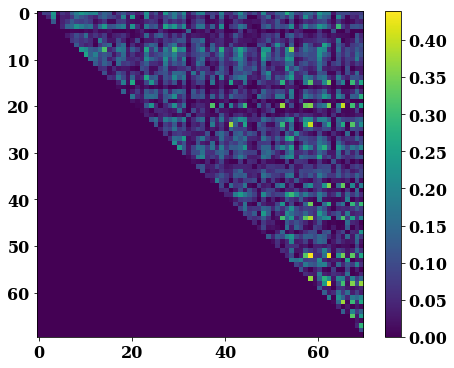

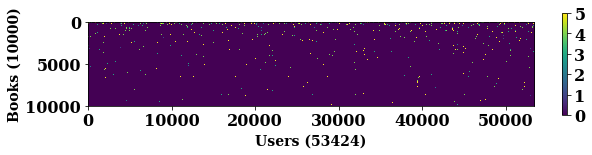

In [152]:
import requests
CLIENT_ID = 'qc6JdYnnj3G1fpQSsp4n1w'
CLIENT_SECRET = 'zD8IroPsQVDvco4V2u9h6hMgV1F3lsIO6FxKiq9eU'

In [ ]:
multi_r = requests.get('https://api.foursquare.com/v2/venues/search?client_id=CLIENT_ID&client_secret=CLIENT_SECRET')


In [223]:
# plt.figure(figsize=(8,6))
# _,_,_ = plt.hist(df_books.average_rating.values,range=(0,5),bins=5)
# plt.grid(True)


In [90]:
ratings = [ ratings_mat[0][i] for i in range(ratings_mat.shape[1]) if ratings_mat[0][i] != 0 ]
print("Average rating for first book: %.2f " % np.mean(ratings))

Average rating for first book: 4.28 


Text(0.5,0,'Users (53424)')

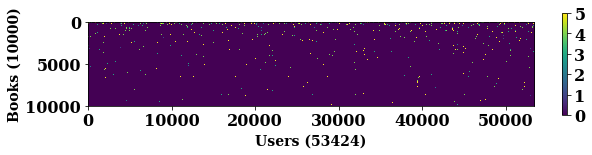

In [52]:
# i-th row of X corresponds to feature vector for the i-th novel x(i), 
# j-th row of Theta corresponds to one parameter vector θ(j), for the j-th user. 
# Here we use n = 100
# X is a nbooks × 100 matrix and Theta is a nusers × 100 matrix.
# Both x(i) and θ(j) are n-dimensional vectors. 


10000


In [47]:
df['average_rating'] = ( df['ratings_1'] + 2*df['ratings_2'] + \
                         3*df['ratings_3'] + 4*df['ratings_4'] + \
                         5*df['ratings_5'] )/ df['ratings_count']

In [48]:
df0 = df.query('original_title == "The Great Gatsby"')
print(df0.average_rating.values)

[4.0178614]


In [151]:
# r = pd.read_csv('goodbooks-10k/br.csv',engine='python')
# df_books_2 = pd.DataFrame(r)
# df_books_2.head()
 